In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from sklearn.linear_model import LinearRegression
import datetime as dt
sb.set() # set the default Seaborn style for graphics

For our prediction model, we plan to use a three step approach to ensure that the customers are exposed to novel articles and yet also make use of their past transactions in this decision making. This is done in the following steps:

1. Choosing top 100 most popular articles by customer age group
2. Choosing the most important and popular attributes based on the customer's transactions within past 3 months
3. Use Image Processing to recommend similar styles for customer

## Extracting Transaction Data

In [2]:
transactiondata = pd.read_csv('transactions.csv')
transactiondata = transactiondata.loc[:, ~transactiondata.columns.str.contains('^Unnamed')]
transactiondata.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565002,0.030492,2
1,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565001,0.030492,2
2,2020-01-02,00067622de3151a7219b4ed9922def50b51601fbe41418...,801865004,0.018627,1
3,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,0.020322,2
4,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,0.020339,2


### Choosing random customer id for prediction

In [4]:
targetcustomerid = transactiondata.iloc[8888]['customer_id']
targetcustomerid

'32b685cdf210e62c55b603fb194a467723a797c93c581532aa4b9ca5f101cf8f'

### Initial Data Cleaning

In [5]:
transactiondf = transactiondata.loc[:,['t_dat', 'customer_id', 'article_id']]
transactiondf.loc[:,'t_dat'] = pd.to_datetime(transactiondf['t_dat'], format='%Y-%m-%d')

max_dat = transactiondf['t_dat'].max()
transactiondf['max_dat'] = max_dat
transactiondf['diff_dat'] = (transactiondf.max_dat - transactiondf.t_dat).dt.days
transactiondf.head()

,t_dat,customer_id,article_id,max_dat,diff_dat
0,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565002,2020-09-22,264
1,2020-01-02,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,797565001,2020-09-22,264
2,2020-01-02,00067622de3151a7219b4ed9922def50b51601fbe41418...,801865004,2020-09-22,264
3,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,2020-09-22,264
4,2020-01-02,0010f56acce349e6e82bfef13ee39232a8bc0db0801ca4...,578752001,2020-09-22,264


# Step 1: Find top 100 articles from mergedDF based on purchase count for all customers

## a) Get CustomerDF within required age range

In [6]:
customerdata = pd.read_csv('customers.csv', usecols=['customer_id', 'age'])
age = customerdata.loc[customerdata['customer_id'] == targetcustomerid]['age'].astype({'age': 'int64'}).values[0]
quotient = age // 10
minage = quotient * 10
maxage = (quotient+1) * 10
scopedCustomerData = customerdata.loc[(customerdata['age'] > minage) & (customerdata['age'] < maxage)]
scopedCustomerData.head()

,customer_id,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0
12,00009c2aeae8761f738e4f937d9be6b49861a66339c2b1...,49.0
17,0000b95f630aaa9313028ce9c41154bb95ac7afa34f55b...,49.0
18,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0
19,0000d6c053fc8f9389d4565051f12402d5774aa4a9d2e5...,41.0


## b) Merge scopedCustomerData with transactiondf on customer_id and find transactions within recent 90 days

In [7]:
mergeddf = scopedCustomerData.merge(transactiondf, on=['customer_id'], how='left')
mergeddfInDateRange = mergeddf.loc[(mergeddf['diff_dat'] <90)]
mergeddfInDateRange.head()

,customer_id,age,t_dat,article_id,max_dat,diff_dat
5,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,2020-09-05,568601043.0,2020-09-22,17.0
13,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,2020-07-22,778064038.0,2020-09-22,62.0
14,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,2020-07-22,817166007.0,2020-09-22,62.0
15,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,2020-07-22,840360002.0,2020-09-22,62.0
16,0000c97821eb48d0e590fd309133f0a6c08f7750f64ccc...,49.0,2020-07-22,817166003.0,2020-09-22,62.0


## c) Get top 100 Articles and Attributes

In [8]:
article_id_count = mergeddfInDateRange.groupby('article_id')['age'].count()
article_id_count

temp = mergeddfInDateRange.groupby(['article_id'])['age'].count()
tempdf = pd.DataFrame({'Article ID': temp.index,
                   'Count': temp.values
                  })
articlesCount = tempdf.sort_values(['Count'], ascending=False)
tophundredarticles = articlesCount.head(100)
tophundredarticles = tophundredarticles.astype({'Article ID': 'int64'})

tophundredarticles.head()

,Article ID,Count
8832,751471001,857
6003,706016001,700
389,372860002,671
11321,783346001,658
17808,841383002,562


In [9]:
articlesdata = pd.read_csv('articles.csv')
selectedArticlesAttributes = articlesdata.loc[(articlesdata['article_id'].isin(tophundredarticles['Article ID']))]
selectedArticlesAttributes

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
74,160442007,160442,3p Sneaker Socks,302,Socks,Socks & Tights,1010016,Solid,9,Black,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Short, fine-knit socks designed to be hidden b..."
75,160442010,160442,3p Sneaker Socks,302,Socks,Socks & Tights,1010016,Solid,10,White,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Short, fine-knit socks designed to be hidden b..."
1713,372860001,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,9,Black,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
1714,372860002,372860,7p Basic Shaftless,302,Socks,Socks & Tights,1010016,Solid,10,White,...,Shopbasket Socks,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.
2252,399256001,399256,Skinny Ankle R.W Brooklyn,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Everyday Waredrobe Denim,A,Ladieswear,1,Ladieswear,57,Ladies Denim,1016,Trousers Denim,Ankle-length jeans in washed stretch denim wit...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103795,915529001,915529,Liliana,252,Sweater,Garment Upper body,1010016,Solid,13,Beige,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo..."
103796,915529003,915529,Liliana,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo..."
104045,918292001,918292,STRONG HW seamless tights,273,Leggings/Tights,Garment Lower body,1010010,Melange,9,Black,...,Ladies Sport Bottoms,S,Sport,26,Sport,5,Ladies H&M Sport,1005,Jersey Fancy,Sports tights in fast-drying functional fabric...
104302,921226001,921226,Edda top(1),254,Top,Garment Upper body,1010016,Solid,9,Black,...,Jersey,A,Ladieswear,1,Ladieswear,11,Womens Tailoring,1005,Jersey Fancy,Cap-sleeved top in softly draping jersey with ...


# Step 2: Choosing the most important and popular attributes based on the customer's transactions within past 3 months

### a) Return top attributes of articles bought by a specific customer within the past 3 months

In [10]:
characteristic_list = ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']
articles_df = articlesdata[characteristic_list]

df = transactiondata.loc[:,['t_dat', 'customer_id', 'article_id']]
df.loc[:,'t_dat'] = pd.to_datetime(df['t_dat'], format='%Y-%m-%d')
max_date_bound = df.t_dat.max()
# print(max_date_bound)

# extract customer 
# most frequent customer
x = mergeddfInDateRange.customer_id.mode()

targetcustomerid = str(x[0])
df = df[(df.customer_id == targetcustomerid) & ((max_date_bound - df.t_dat).dt.days <= 90)]
df = df.merge(articles_df, on=['article_id'], how='left')

# category = 'product_type_name'

# x.index[0]
# x.values[1][0]
characteristic_count = []
for category in characteristic_list[1:]:
    results_df = pd.DataFrame(df[category].value_counts())
    for i in range(len(results_df.index)):
        result = [category, results_df.index[i], results_df.values[i][0]]
#         print(result)
        characteristic_count.append(result)

characteristic_count_df = pd.DataFrame(characteristic_count, columns = ['Category', 'Value', 'Count'])

characteristic_count_df = characteristic_count_df.sort_values('Count', ascending=False)
idx = characteristic_count_df.groupby(['Category'], sort=False)['Count'].transform(max) == characteristic_count_df['Count']
topcharacteristics = characteristic_count_df[idx]
topcharacteristics

,Category,Value,Count
157,index_group_name,Ladieswear,285
151,index_name,Ladieswear,256
39,graphical_appearance_name,Solid,236
86,perceived_colour_value_name,Dark,159
92,perceived_colour_master_name,Black,139
31,product_group_name,Garment Full body,139
55,colour_group_name,Black,138
0,product_type_name,Dress,132
161,section_name,Womens Everyday Collection,113
182,garment_group_name,Blouses,60


## b) Apply feature importance (Chi Squared) as weights to the absolute counts for each category

The feature importance is trained on past 90 transaction data of customers around the age group of the previously selected customer

In [11]:
# merge scoped transaction data with articles bought
merged_chisquared = pd.merge(mergeddfInDateRange,articlesdata,on='article_id')

Feature 0 product_group_name: 895496.609255
Feature 1 graphical_appearance_name: 229774.261237
Feature 2 colour_group_name: 723781.742803
Feature 3 perceived_colour_value_name: 16115.741790
Feature 4 perceived_colour_master_name: 278879.098178
Feature 5 department_name: 6703850.810011
Feature 6 index_name: 44822.359506
Feature 7 index_group_name: 17254.433340
Feature 8 section_name: 663318.440579
Feature 9 garment_group_name: 1585625.287810


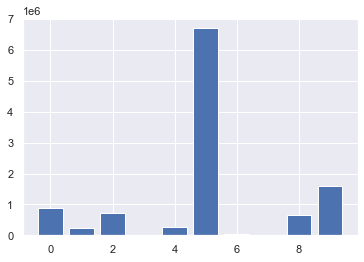

In [12]:
# chi squared feature selection for categorical data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot



attributes = ['product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']
# load the dataset
def load_dataset(articles):
    article_attr = articles[attributes]
    dataset = article_attr.values
    X = dataset[:, 1:]
    y = dataset[:,0]
    # format all fields as string
    X = X.astype(str)
    return X, y

# prepare input data
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

# prepare target
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc

# feature selection
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# load the dataset HERE
X, y = load_dataset(merged_chisquared)
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.0005, random_state=1)
# prepare input data
X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)
# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train_enc, y_train_enc, X_test_enc)
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d %s: %f' % (i, attributes[i+1], fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [13]:
# calculating weights 
weights = [(x/sum(fs.scores_)) for x in fs.scores_]
weights

[0.08024940646561876,
 0.02059108643713013,
 0.06486127883716743,
 0.0014442028032808773,
 0.024991587766075022,
 0.6007616812586821,
 0.004016729610771767,
 0.0015462459825737658,
 0.05944289526507361,
 0.1420948855736267]

## c) Updated feature ranking of each customer with new weights 

In [14]:
attributes_temp = ['product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for i in attributes_temp:
    topcharacteristics.loc[topcharacteristics.Category == i, "Weights"] = weights[attributes_temp.index(i)]

topcharacteristics["Weighted Count"] = topcharacteristics["Count"]*topcharacteristics["Weights"]
topcharacteristics.sort_values(by='Weighted Count', ascending=False)

/Users/danielyang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/danielyang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-14-a696d51aa585>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,Category,Value,Count,Weights,Weighted Count
107,department_name,Dress,49,0.600762,29.437322
31,product_group_name,Garment Full body,139,0.080249,11.154667
55,colour_group_name,Black,138,0.064861,8.950856
182,garment_group_name,Blouses,60,0.142095,8.525693
161,section_name,Womens Everyday Collection,113,0.059443,6.717047
39,graphical_appearance_name,Solid,236,0.020591,4.859496
92,perceived_colour_master_name,Black,139,0.024992,3.473831
151,index_name,Ladieswear,256,0.004017,1.028283
157,index_group_name,Ladieswear,285,0.001546,0.440680
86,perceived_colour_value_name,Dark,159,0.001444,0.229628


### d) Combine Steps 1 and 2 to select Articles that are the top 100 in customer age group and possess the most characteristics of popular articles

In [15]:
oldArticlesAttributes = selectedArticlesAttributes
for index, row in topcharacteristics.iterrows():
  category = row[0]
  value = row[1]
  selectedArticlesAttributes = selectedArticlesAttributes.loc[selectedArticlesAttributes[category] == value]
  if selectedArticlesAttributes.empty:
    selectedArticlesAttributes = oldArticlesAttributes
  oldArticlesAttributes = selectedArticlesAttributes
    
selectedArticlesAttributes

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
67522,751471001,751471,Pluto RW slacks (1),272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
75912,783346001,783346,Primo slacks,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length cigarette trousers in a stretch w...
84638,816563001,816563,Drizzle,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers,Ankle-length trousers in a softly draping weav...
94674,863595006,863595,Baraboom throw-on,245,Cardigan,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Long cardigan in a soft, fine knit containing ..."
102911,907696002,907696,Jinny smock top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey fancy,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1005,Jersey Fancy,"Fitted, smocked top in soft cotton jersey with..."
103796,915529003,915529,Liliana,252,Sweater,Garment Upper body,1010016,Solid,9,Black,...,Knitwear,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1003,Knitwear,"Jumper in a soft, fine knit containing some wo..."


## e) Find Predicted Price of selected Articles

In [16]:
expectedPriceDF = pd.DataFrame(columns = ['article_id', 'expectedPrice'])
for index, row in selectedArticlesAttributes.iterrows():
    article_id = row[0]
    transactionDataPerArticle = transactiondata.loc[transactiondata['article_id'] == article_id]
    transactionDataPerArticle['t_dat'] = pd.to_datetime(transactionDataPerArticle['t_dat'])
    newpurchasedate = transactionDataPerArticle.iloc[-1]['t_dat'] + pd.DateOffset(days = 7)
    newpurchasedate = newpurchasedate.toordinal()
    
    price = pd.DataFrame(transactionDataPerArticle['price'])           # Response
    dates = pd.DataFrame(transactionDataPerArticle['t_dat'])         # Predictor
    transactionDataPerArticle['t_dat'] = pd.to_datetime(transactionDataPerArticle['t_dat'])
    dates['t_dat'] = (dates['t_dat'].apply(lambda date: date.toordinal()))
    newpurchasedatedf = pd.DataFrame([newpurchasedate], columns=['t_dat'])

    # Linear Regression using Train Data
    linreg = LinearRegression()         # create the linear regression object
    linreg.fit(dates, price)        # train the linear regression model

    result = linreg.predict(newpurchasedatedf)
    expectedPriceOfArticle = result[0][0]
    newDF = pd.DataFrame({'article_id': [article_id],
                    'expectedPrice' : [expectedPriceOfArticle]})
    expectedPriceDF = pd.concat([newDF, expectedPriceDF], ignore_index = True, axis = 0)
expectedPriceDF = expectedPriceDF.sort_values(by='expectedPrice', ascending=False)
display(expectedPriceDF)

<ipython-input-16-f0c613a05f0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactionDataPerArticle['t_dat'] = pd.to_datetime(transactionDataPerArticle['t_dat'])
<ipython-input-16-f0c613a05f0d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactionDataPerArticle['t_dat'] = pd.to_datetime(transactionDataPerArticle['t_dat'])
<ipython-input-16-f0c613a05f0d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,article_id,expectedPrice
0,915529003,0.033498
5,751471001,0.033347
2,863595006,0.033229
3,816563001,0.025387
4,783346001,0.025032
1,907696002,0.016662


## f) Find mean Price of transactions made by customer

In [17]:
customerspendingdf = transactiondata.loc[transactiondata['customer_id'] == targetcustomerid]
meanPrice = customerspendingdf['price'].mean()
meanPrice

0.03770883930487011

## g) Find selected Article with predicted price closest to mean price of transactions made by customer

In [38]:
result_index = expectedPriceDF['expectedPrice'].sub(meanPrice).abs().idxmin()
finalPredictedID = expectedPriceDF.loc[[result_index]]['article_id']
finalPredictedID

'0362997011'

# Step 3: Use Image Processing to recommend similar styles for customer

## ResNet50 with Euclidean distance

## 1st 50K articles

In [39]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
from PIL import Image
import pickle
from datetime import datetime
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import streamlit as st
#use the below library while displaying the images in jupyter notebook
from IPython.display import display, Image

In [40]:
articles = pd.read_csv('./articles.csv')
a_copy = articles.copy()
df_Productids = list(a_copy['article_id'])

In [41]:
extracted_features = np.load('/Users/danielyang/Desktop/DSAI Lab/hm_50k.npy')
Productids1 = np.load('/Users/danielyang/Desktop/DSAI Lab/hm_product_ids_50k.npy')
Productids1 = list(Productids1)
def get_similar_products_cnn1(product_id, num_results):
    doc_id = Productids1.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids1[indices[0]])]
#     print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + str(product_id)[0:3]+'/'+str(product_id)+'.jpg', width = 224, height = 224,embed=True))
        print('Product Title: ', row['prod_name'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids1[indices[i]])]
#         print(rows)
        for indx, row in rows.iterrows():
            display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + '0' + str(row['article_id'])[0:2] +'/'+ "0" +str(row['article_id'])+'.jpg', width = 224, height = 224,embed=True))
            print('Product Title: ', row['prod_name'])
            print('Euclidean Distance from input image:', pdists[i])

## 50K - 105k articles

In [32]:
extracted_features = np.load('/Users/danielyang/Desktop/DSAI Lab/57k_features_2.npy')
Productids2 = np.load('/Users/danielyang/Desktop/DSAI Lab/57k_ids_2.npy')
Productids2 = list(Productids2)
def get_similar_products_cnn2(product_id, num_results):
    doc_id = Productids2.index(product_id)
    pairwise_dist = pairwise_distances(extracted_features, extracted_features[doc_id].reshape(1,-1))
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    print("="*20, "input product image", "="*20)
    ip_row = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids2[indices[0]])]
#     print(ip_row.head())
    for indx, row in ip_row.iterrows():
        display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + str(product_id)[0:3]+'/'+str(product_id)+'.jpg', width = 224, height = 224,embed=True))
        print('Product Title: ', row['prod_name'])
    print("\n","="*20, "Recommended products", "="*20)
    for i in range(1,len(indices)):
        rows = a_copy[['article_id','prod_name']].loc[a_copy['article_id']==int(Productids2[indices[i]])]
#         print(rows)
        for indx, row in rows.iterrows():
            display(Image(filename = "/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images/" + '0' + str(row['article_id'])[0:2] +'/'+ "0" +str(row['article_id'])+'.jpg', width = 224, height = 224,embed=True))
            print('Product Title: ', row['prod_name'])
            print('Euclidean Distance from input image:', pdists[i])

==================== input product image ====================


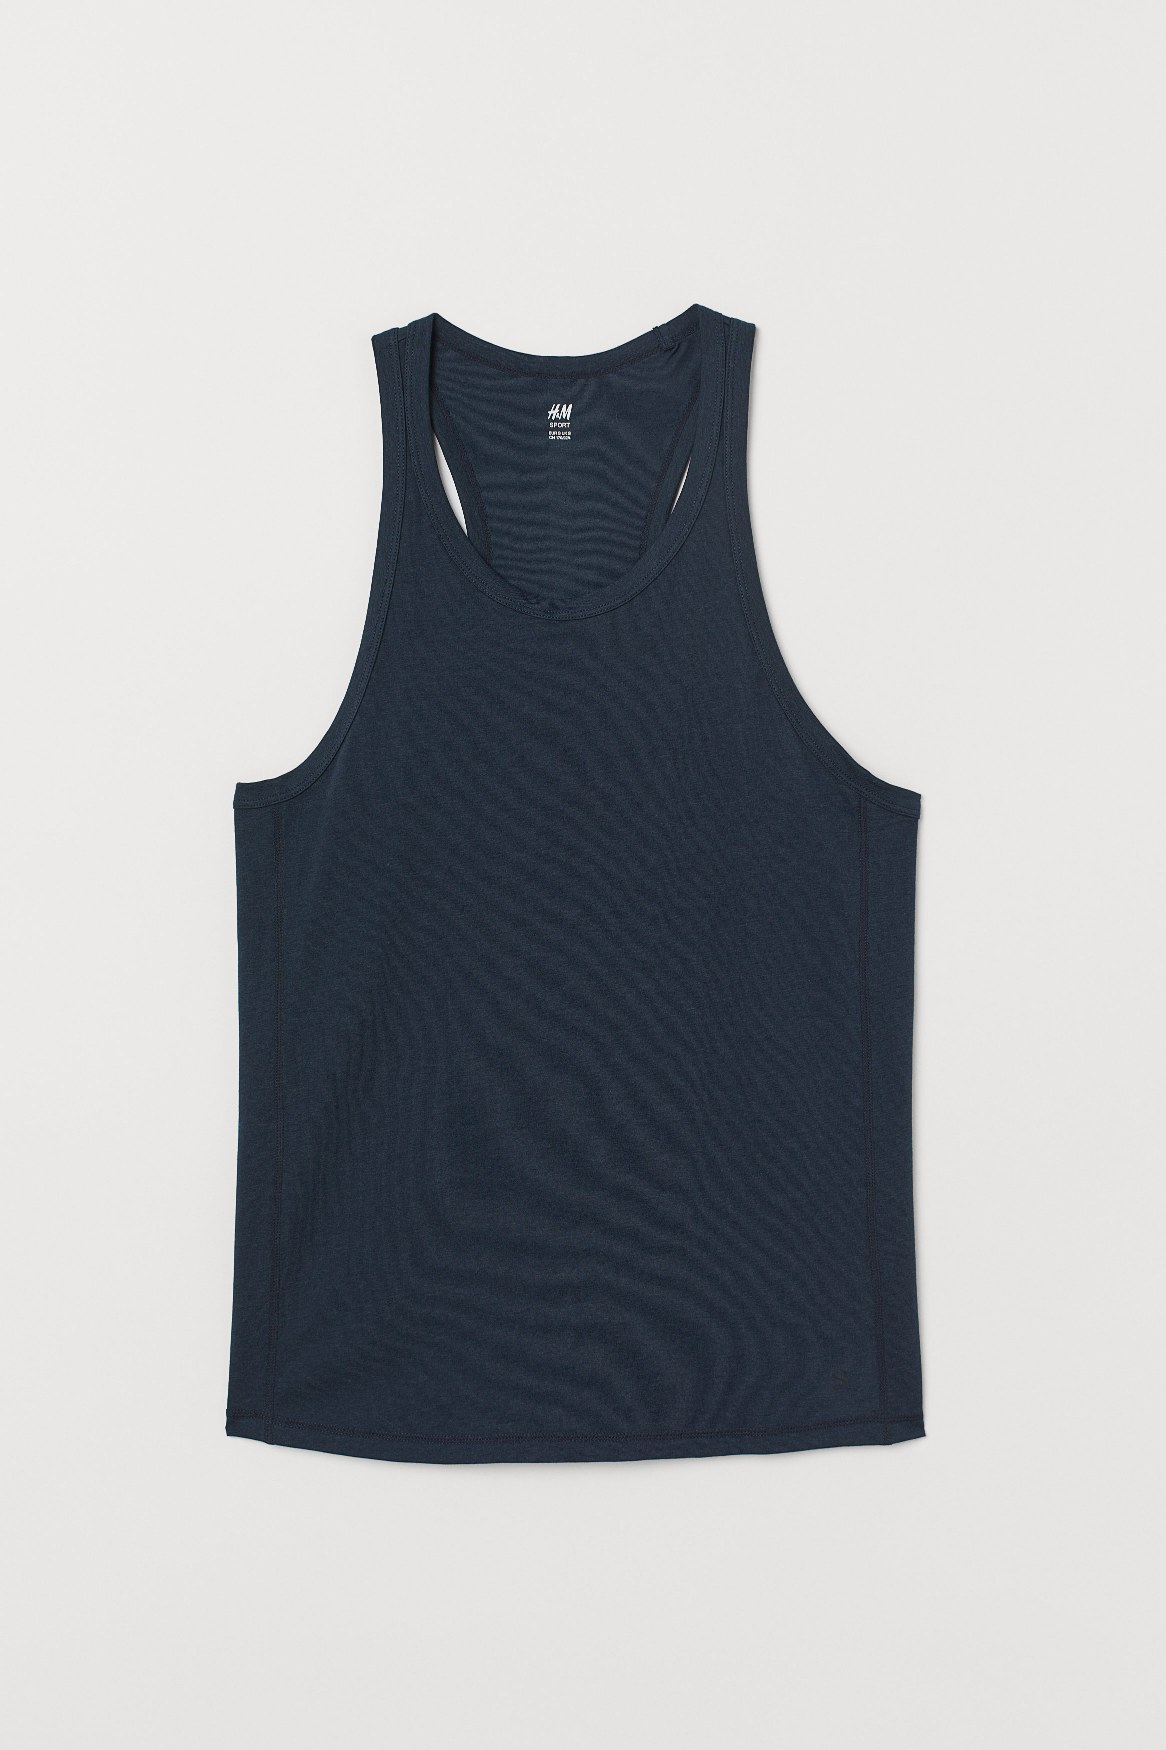

Product Title:  Miami tanktop

 ==================== Recommended products ====================


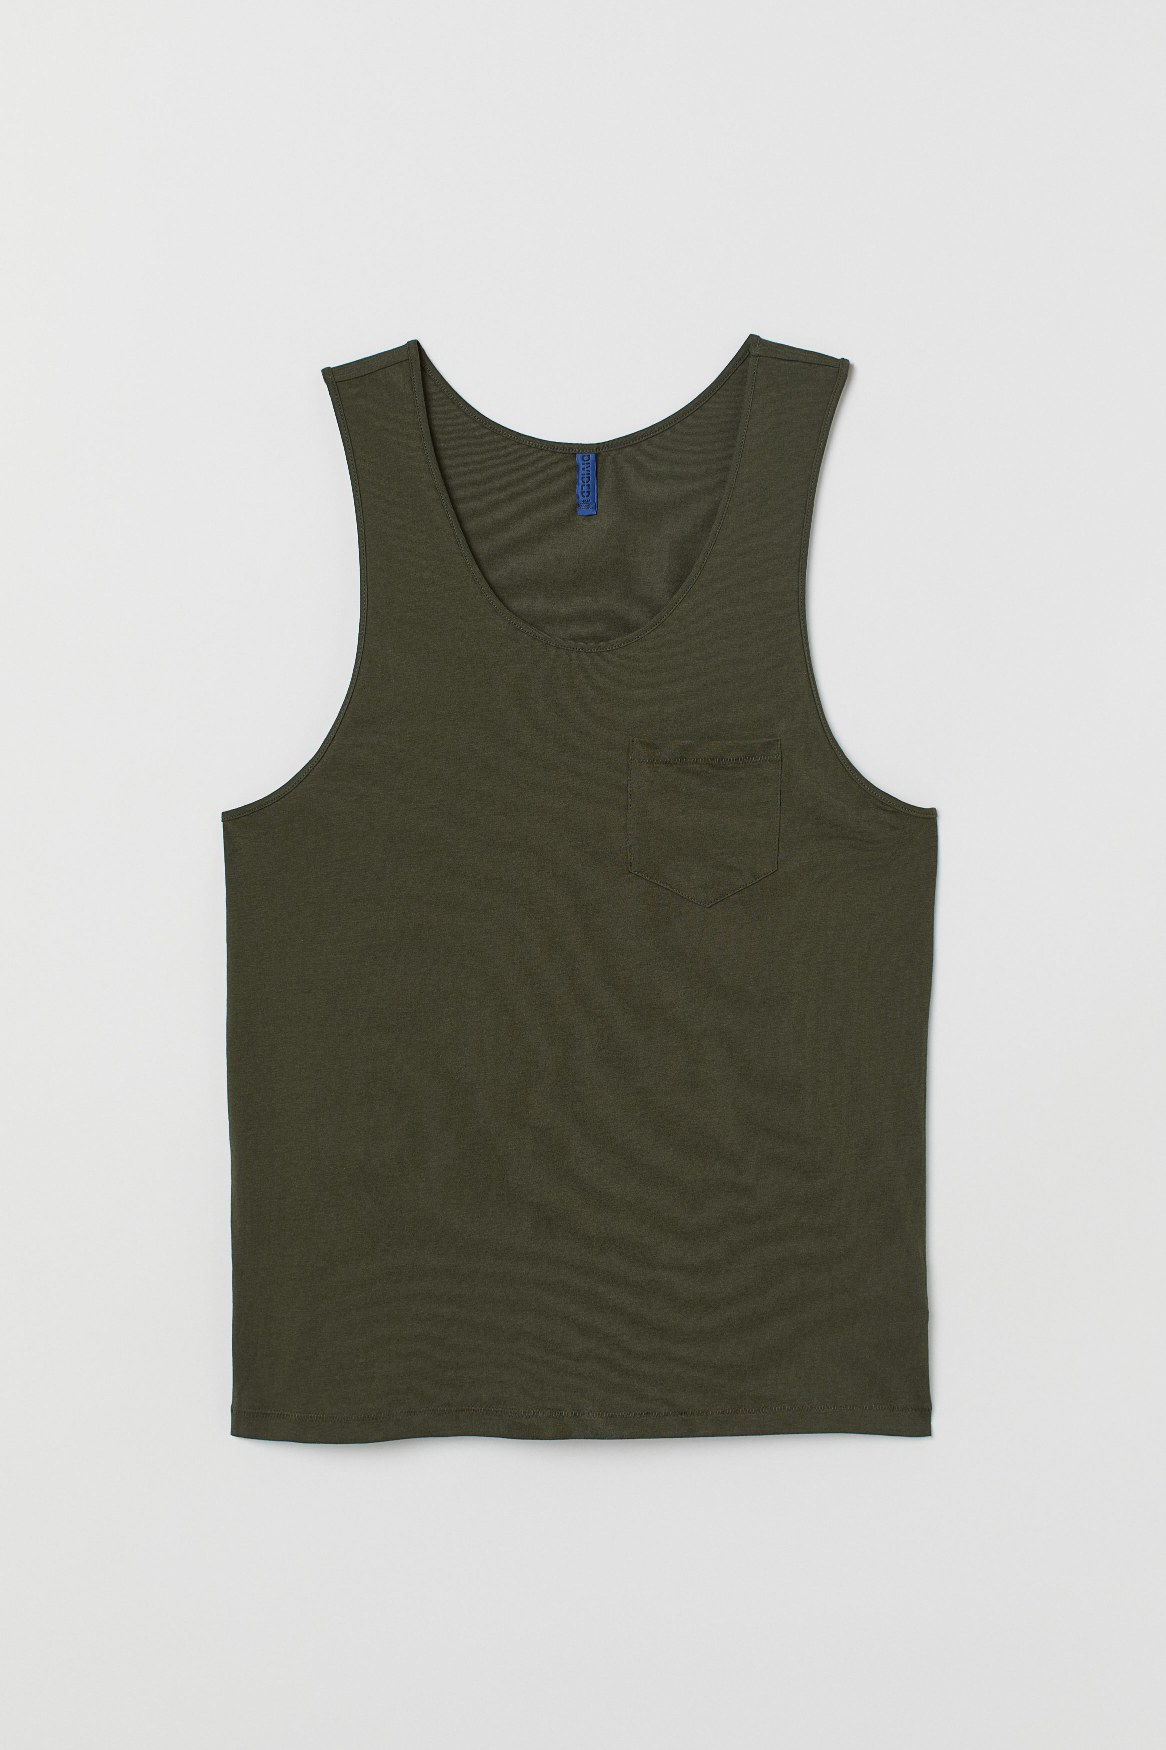

Product Title:  Frank Tank
Euclidean Distance from input image: 19.377268


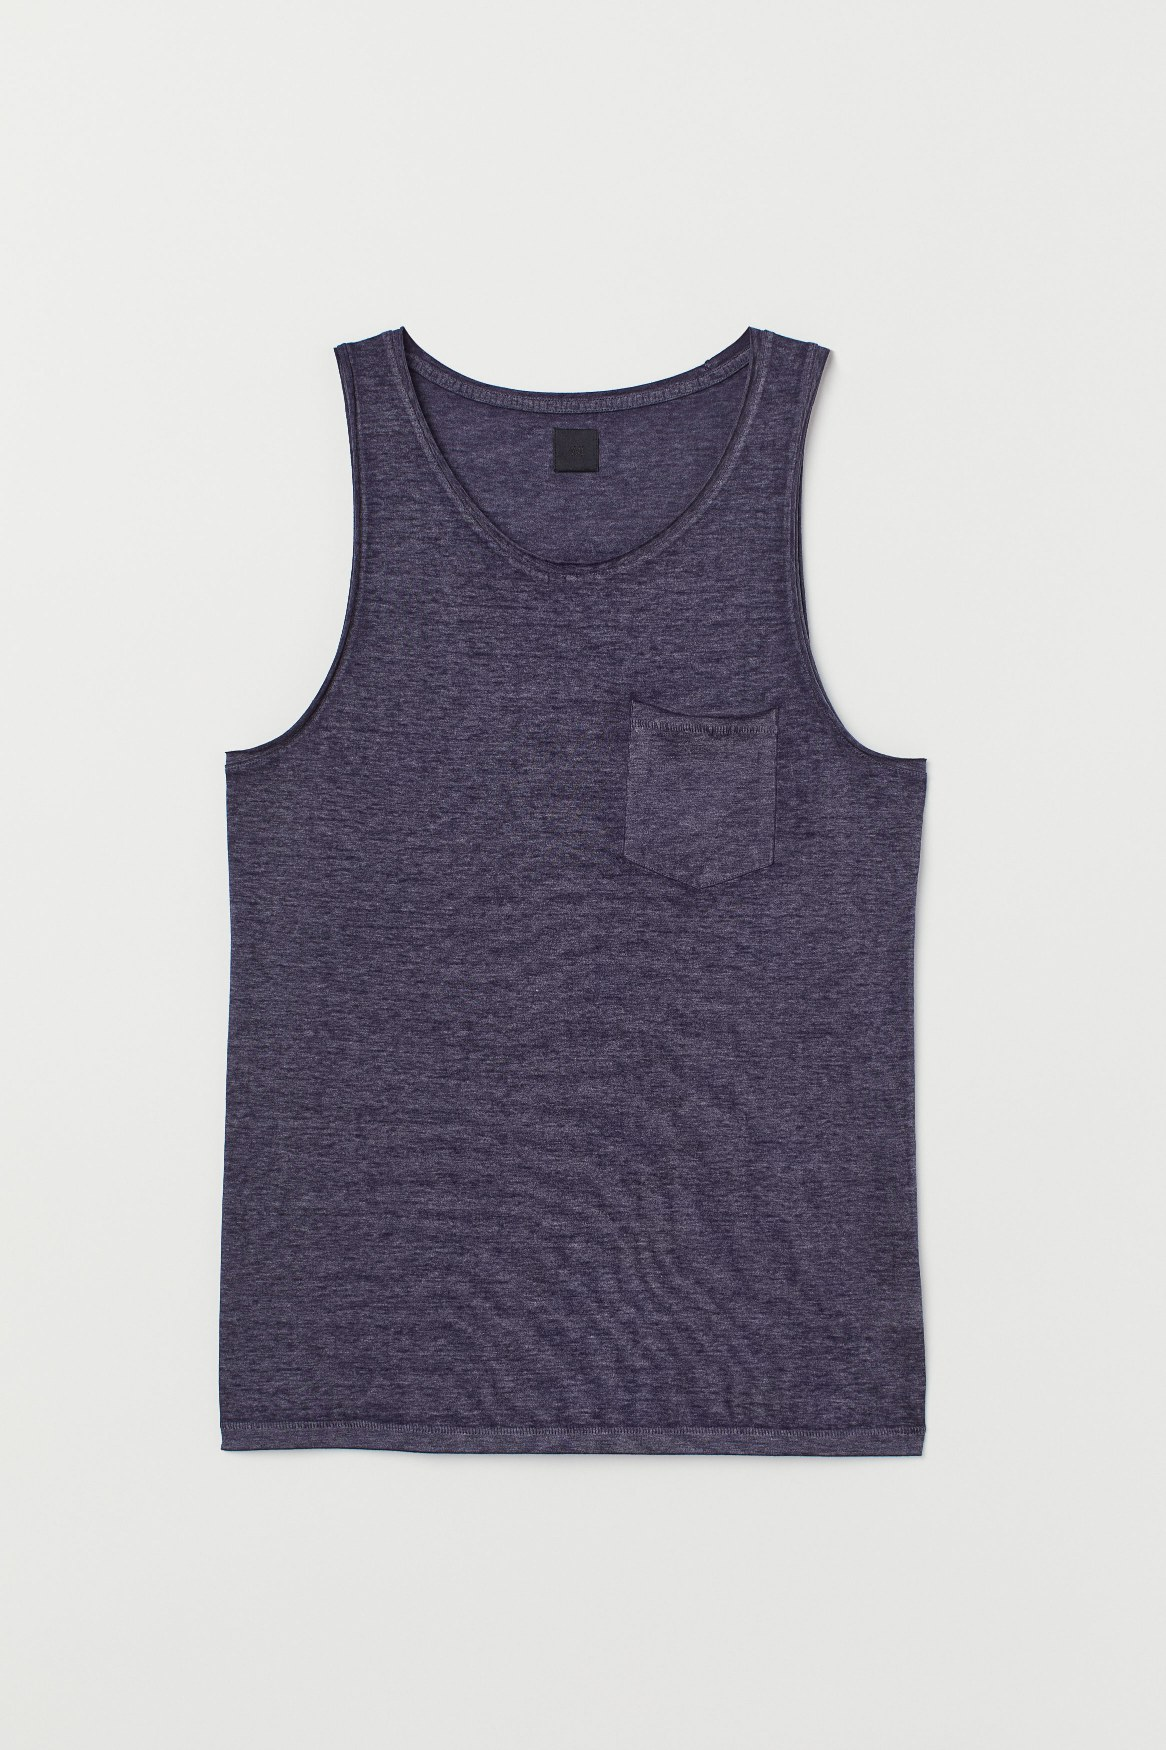

Product Title:  CORBY TANK
Euclidean Distance from input image: 20.71118


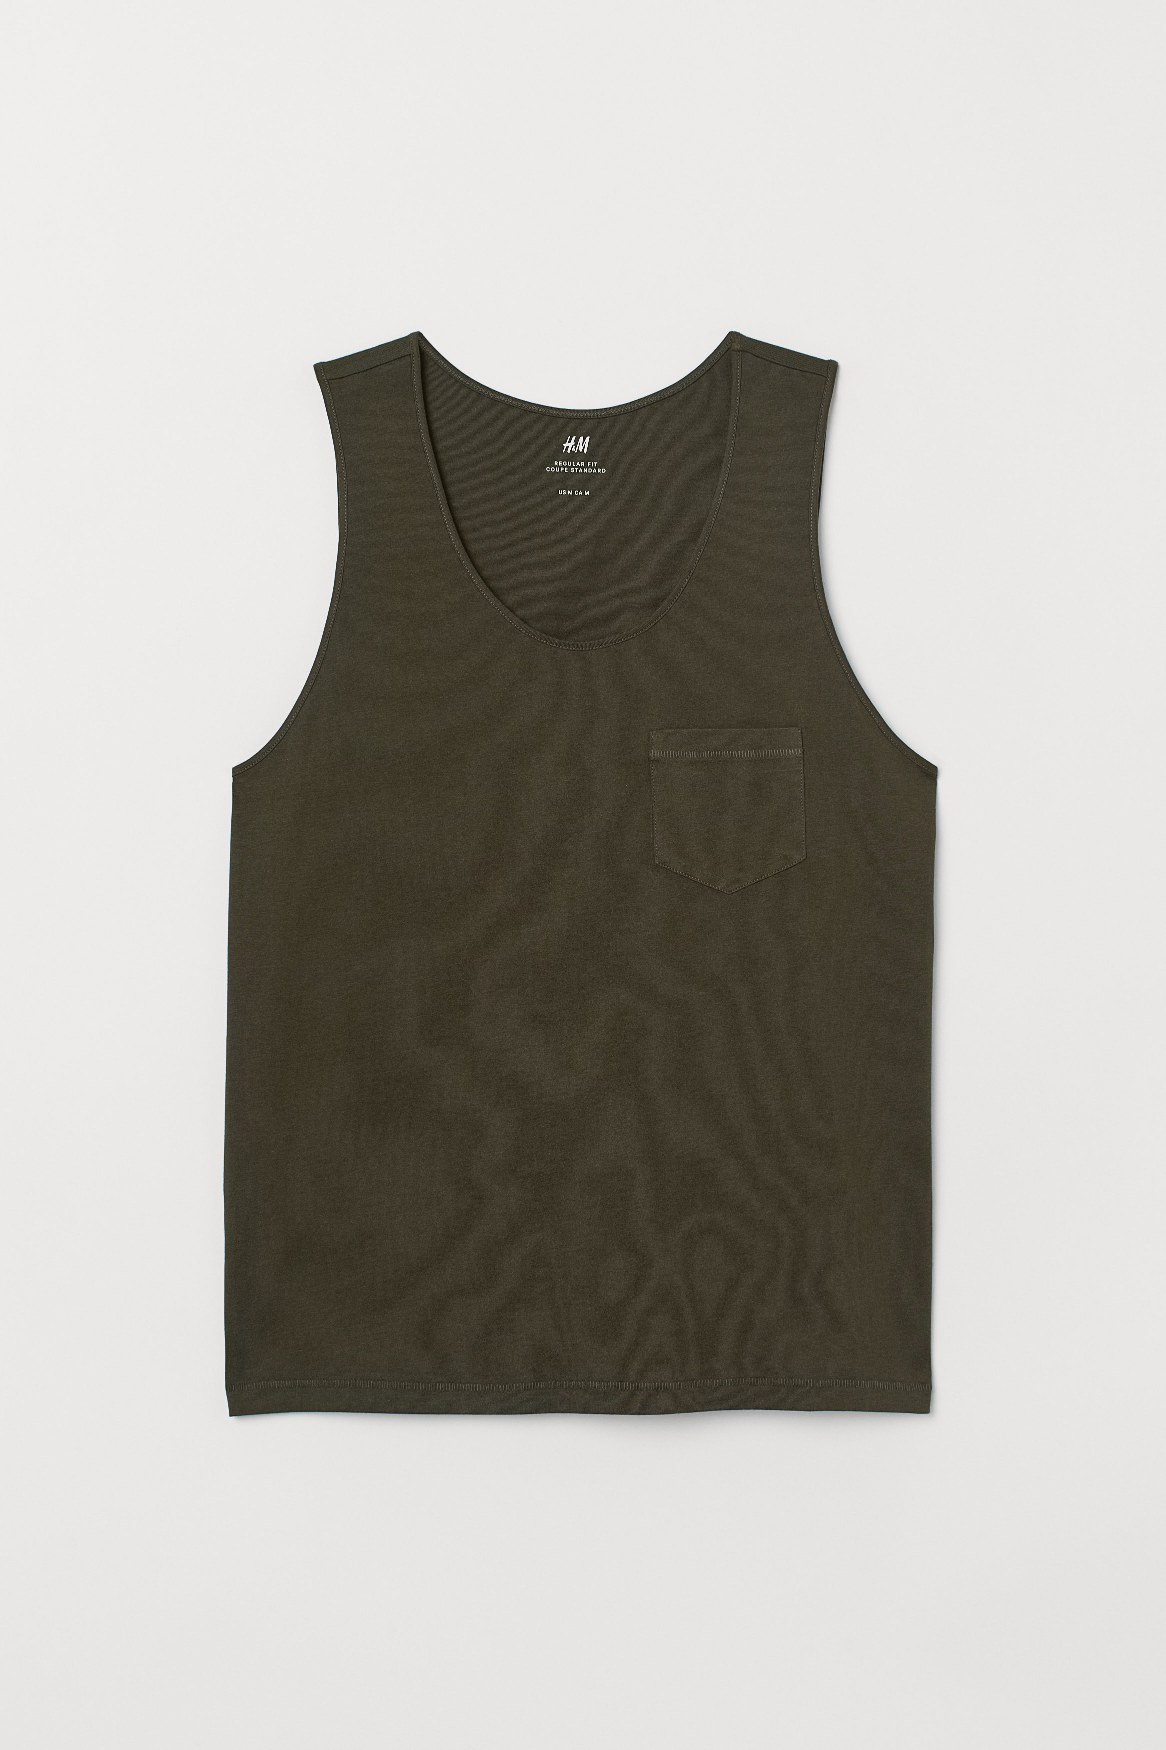

Product Title:  Frank Tank
Euclidean Distance from input image: 21.355795


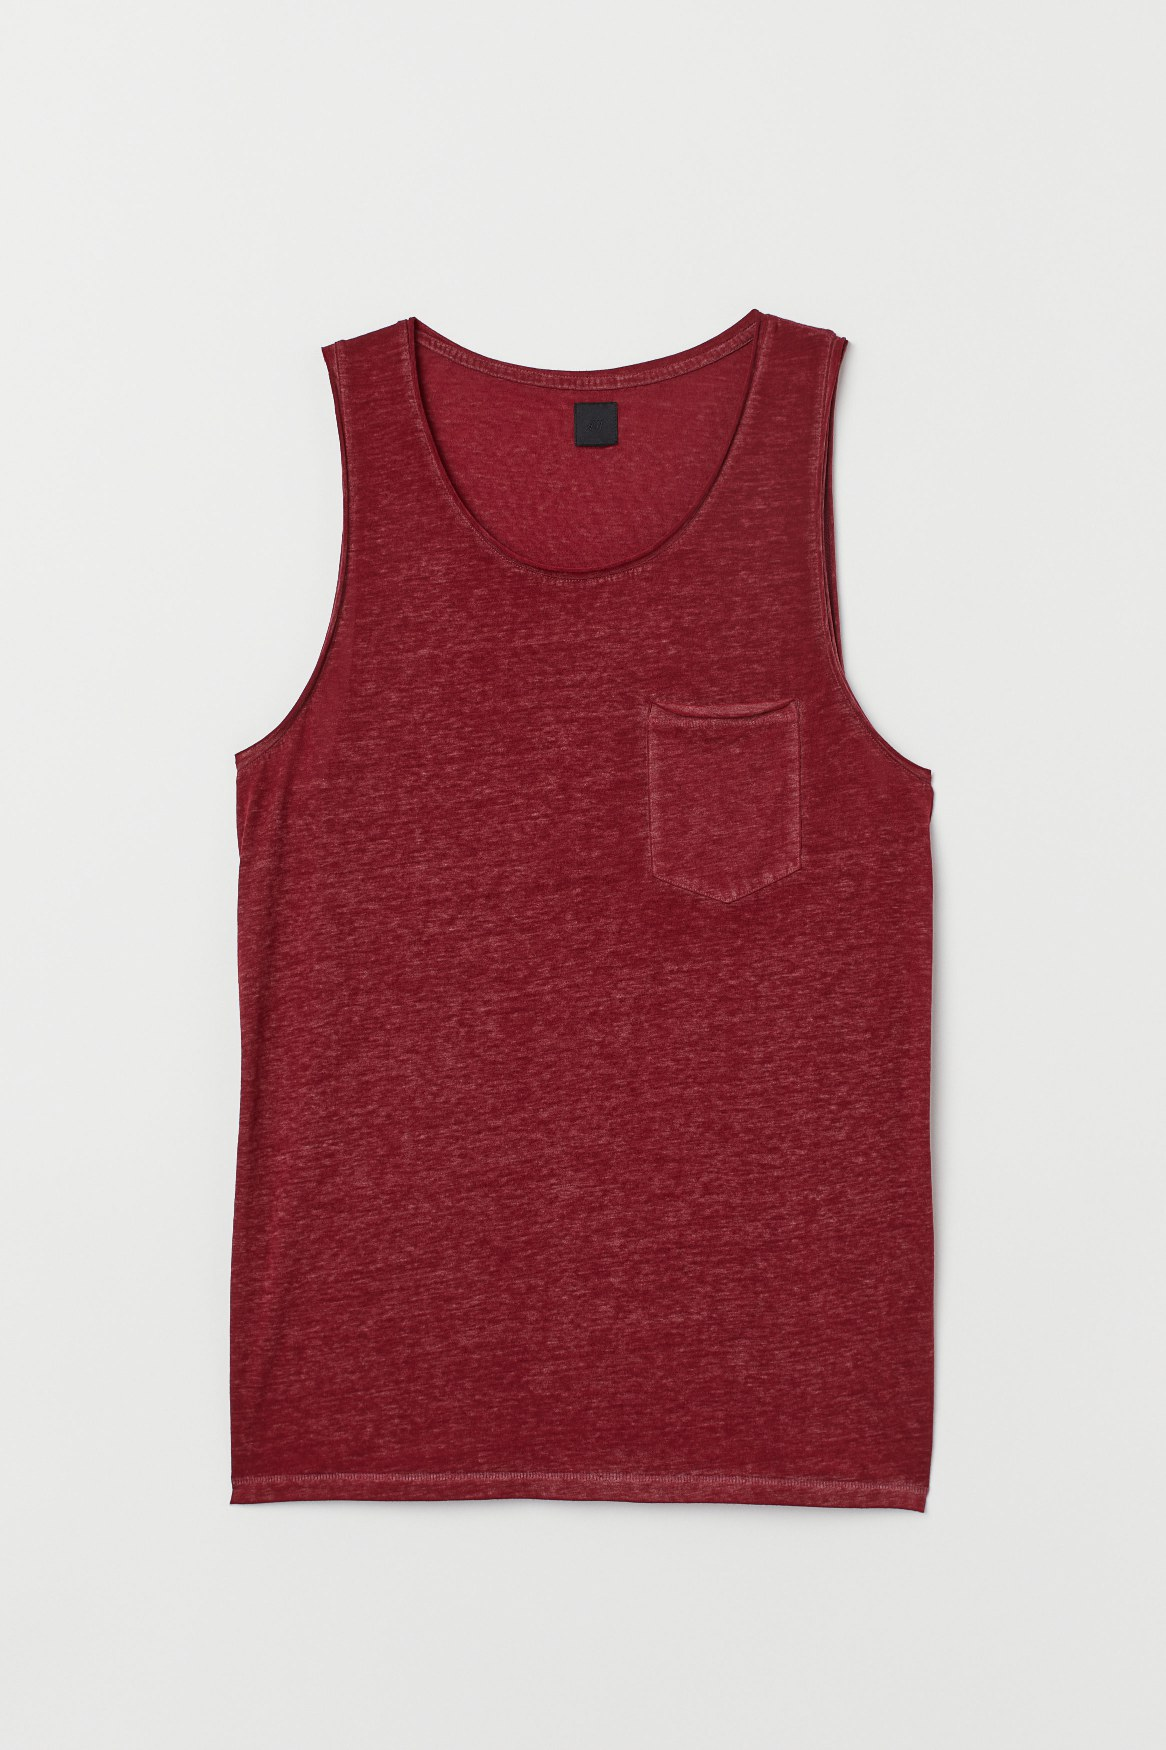

Product Title:  CORBY TANK
Euclidean Distance from input image: 22.657051


In [43]:
get_similar_products_cnn1(finalPredictedID, 5)

## Xception model with cosine similarity

In [27]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from keras.applications.xception import Xception,preprocess_input
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Input
from keras.backend import reshape
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

images_dir = '/Users/danielyang/Downloads/h-and-m-personalized-fashion-recommendations/images'
articles = pd.read_csv('./articles.csv')

def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in sorted(os.walk(path)):
        for filename in sorted(filenames):
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

def preprocess_img(img_path):
    dsize = (225,225)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image=preprocess_input(new_image)
    return new_image

def load_data():
    output=[]
    output=getImagePaths(images_dir)[0:10000]
    return output
def model():
    model=Xception(weights='imagenet',include_top=False)
    for layer in model.layers:
        layer.trainable=False
        #model.summary()
    return model

def feature_extraction(image_data,model):
    features=model.predict(image_data)
    features=np.array(features)
    features=features.flatten()
    return features
def result_vector_cosine(model,feature_vector,new_img):
    new_feature = model.predict(new_img)
    new_feature = np.array(new_feature)
    new_feature = new_feature.flatten()
    N_result = 12
    nbrs = NearestNeighbors(n_neighbors = N_result, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    return(indices)
def input_show(data, index):
    title = "Query Image Title:"+ " " + articles[articles["article_id"] == int(index[-13:-4])]["prod_name"].item()
    plt.grid(False)
    plt.title(title)
    plt.imshow(data)
  
def show_result(data,result):
    fig = plt.figure(figsize=(14,10))
    for i in range(0,6):
        index_result=result[0][i]
        plt.subplot(2,3,i+1)
        plt.imshow(cv2.imread(data[index_result]))
#         print(index_result)
        title = "Product Title:"+ " " + articles[articles["article_id"] == int(output[index_result][-13:-4])]["prod_name"].item()
        plt.title(title)
        plt.grid(False)
    plt.show()

features = np.load('./xception_10k.npy')

output=load_data()
main_model=model()

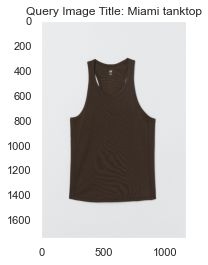

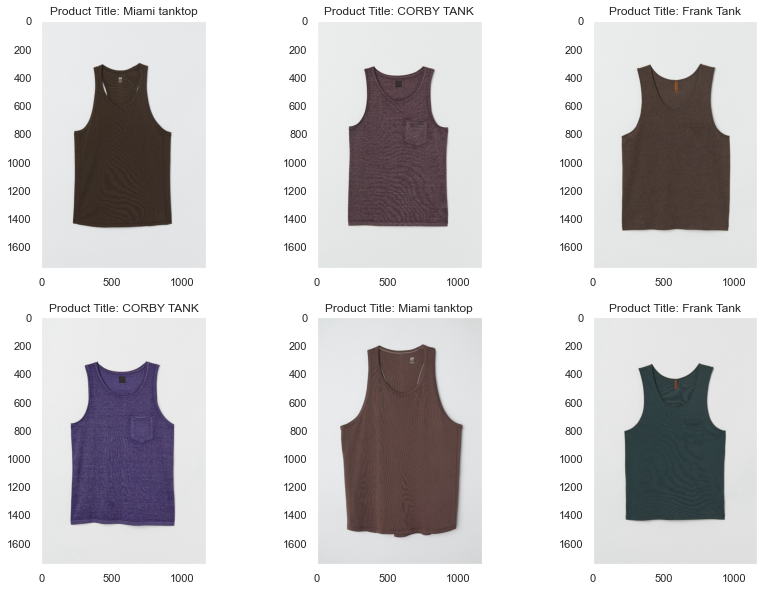

In [36]:
feature_vec = np.array(features)
result=result_vector_cosine(main_model,feature_vec,preprocess_img(output[selected_articleID]))
input_show(cv2.imread(output[selected_articleID]),output[selected_articleID])
show_result(output,result)